In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import timeit

import matrix_lib
from importlib import reload
reload(matrix_lib)

from numba import jit, njit, cuda, prange

# Matrix initialization

In [3]:
def init_mat(nrows, ncols):
    return [[np.random.randint(0, 100) for _ in range(ncols)] for _ in range(nrows)]

def init_mat_fast(nrows, ncols):
    return np.random.randint(0, 100, (nrows, ncols))

display( init_mat(5,5) )
display( init_mat_fast(5,5) )

[[91, 48, 89, 27, 56],
 [77, 92, 95, 13, 37],
 [1, 0, 68, 78, 23],
 [46, 44, 60, 77, 97],
 [96, 61, 27, 55, 82]]

array([[83, 62, 61, 72, 28],
       [96, 98, 27, 71, 23],
       [78, 49, 87, 87, 89],
       [75, 36, 73, 49, 28],
       [90, 29, 99, 62,  0]])

# Custom matrix addition and multiplication

In [4]:
def add(mat1, mat2):
    print( "custom matrix addition" )
    nrows = len(mat1[:])
    ncols = len(mat1[0])
    return [[ mat1[i][j] + mat2[i][j] for j in range(ncols) ] for i in range(nrows)]

mat1 = init_mat_fast(5,5)
mat2 = init_mat_fast(5,5)
# add(mat1, mat2)
matrix_lib.custom_add(mat1, mat2)

custom matrix addition


[[82, 41, 82, 135, 176],
 [92, 99, 15, 97, 40],
 [88, 65, 103, 77, 52],
 [110, 82, 90, 98, 54],
 [46, 101, 119, 77, 54]]

In [5]:
def mul(mat1, mat2):
    print( "custom matrix multiplication" )
    nrows_mat1 = len(mat1[:])
    nrows_mat2 = len(mat2[:])
    ncols_mat1 = len(mat1[0])
    ncols_mat2 = len(mat2[0])
    
    # Check if multiplication is valid
    if nrows_mat1 != ncols_mat2 or nrows_mat2 != ncols_mat1:
        raise ValueError("Cannot multiply")

    # Initialize the result matrix
    result = init_mat_fast(nrows_mat1, ncols_mat2)
    
    # Perform multiplication
    result = mul_inside(result, mat1, mat2, nrows_mat1, ncols_mat2, ncols_mat1)

    return result

def mul_inside(result, mat1, mat2, nrows_mat1, ncols_mat2, ncols_mat1):
    for i in range(nrows_mat1):
        for j in range(ncols_mat2):
            for k in range(ncols_mat1):
                result[i][j] += mat1[i][k] * mat2[k][j]
    return result 


mat1 = init_mat_fast(5,5)
mat2 = init_mat_fast(5,5)
# nrows_mat1, ncols_mat1 = len(mat1[:]), len(mat1[0])
# nrows_mat2, ncols_mat2 = len(mat2[:]), len(mat2[0])
# result = init_mat_fast(nrows_mat1, ncols_mat2)
# mul_inside(result, mat1, mat2, nrows_mat1, ncols_mat2, ncols_mat1)

matrix_lib.custom_mul(mat1, mat2)

custom matrix multiplication


array([[24877,  8653, 13827, 11705, 12107],
       [14679,  2861,  6726,  6696,  6071],
       [20822,  6505,  7591,  9069, 11592],
       [20163,  6801, 10236,  9903, 10330],
       [10979,  3456,  9120,  9346,  4952]])

# Plots

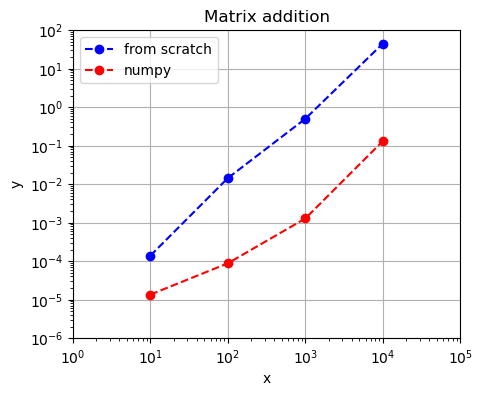

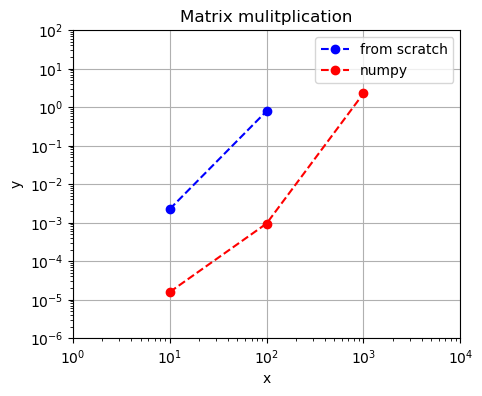

In [5]:
# Addition
plt.figure( figsize=(5,4) )
plt.title( 'Matrix addition' )
plt.plot([10,100,1000,10000], [0.000138, 0.0143, 0.498, 44.6], '--ob', label='from scratch')
plt.plot([10,100,1000,10000], [1.35e-05, 8.76e-05, 0.00128, 0.131], '--or', label='numpy')
plt.xlabel('x')
plt.ylabel('y')
plt.xscale('log')
plt.yscale('log')
plt.xlim([1, 1e5])
plt.ylim([1e-6, 1e2])
plt.grid('on')
plt.legend()
plt.show()

# Multiplication
plt.figure( figsize=(5,4) )
plt.title( 'Matrix mulitplication' )
plt.plot([10,100], [0.00224, 0.787], '--ob', label='from scratch')
plt.plot([10,100,1000], [1.57e-05, 0.000945, 2.26], '--or', label='numpy')
plt.xlabel('x')
plt.ylabel('y')
plt.xscale('log')
plt.yscale('log')
plt.xlim([1, 10000])
plt.ylim([1e-6, 1e2])
plt.grid('on')
plt.legend()
plt.show()

# Numba

In [ ]:
# @njit (No Python Mode) + parallel=True
# @njit is a stricter version of @jit, disabling Python API calls for better performance.
# The parallel=True argument enables multithreading for parallel execution.

# @cuda.jit (GPU Acceleration)
# The @cuda.jit decorator compiles functions to run on NVIDIA GPUs using CUDA.
# It allows direct control over threads and blocks.

In [9]:
@njit(parallel=True)
def add_njit(mat1, mat2):
    nrows = len(mat1[:])
    ncols = len(mat1[0])
    return [[ mat1[i][j] + mat2[i][j] for j in range(ncols) ] for i in range(nrows)]

def mul_njit(mat1, mat2, range='prange'):
    nrows_mat1 = len(mat1[:])
    nrows_mat2 = len(mat2[:])
    ncols_mat1 = len(mat1[0])
    ncols_mat2 = len(mat2[0])
    if nrows_mat1 != ncols_mat2 or nrows_mat2 != ncols_mat1:
        raise ValueError("Cannot multiply")
    result = init_mat_fast(nrows_mat1, ncols_mat2)
    if range == 'range':
        result = mul_inside_njit_range(result, mat1, mat2, nrows_mat1, ncols_mat2, ncols_mat1)
    else:
        result = mul_inside_njit_prange(result, mat1, mat2, nrows_mat1, ncols_mat2, ncols_mat1)
    return result

@njit(parallel=True)
def mul_inside_njit_range(result, mat1, mat2, nrows_mat1, ncols_mat2, ncols_mat1):
    for i in range(nrows_mat1):
        for j in range(ncols_mat2):
            for k in range(ncols_mat1):
                result[i][j] += mat1[i][k] * mat2[k][j]
    return result 

@njit(parallel=True)
def mul_inside_njit_prange(result, mat1, mat2, nrows_mat1, ncols_mat2, ncols_mat1):
    for i in prange(nrows_mat1):
        for j in prange(ncols_mat2):
            for k in prange(ncols_mat1):
                result[i][j] += mat1[i][k] * mat2[k][j]
    return result 

In [10]:
mat1 = init_mat_fast(5,5)
mat2 = init_mat_fast(5,5)
mul_njit(mat1, mat2)
# nrows_mat1, ncols_mat1 = len(mat1[:]), len(mat1[0])
# nrows_mat2, ncols_mat2 = len(mat2[:]), len(mat2[0])
# result = init_mat_fast(nrows_mat1, ncols_mat2)

# mul_inside_jit(result, mat1, mat2, nrows_mat1, ncols_mat2, ncols_mat1)

array([[ 8290, 12708, 16125, 13296, 18158],
       [10662, 16083, 18792, 18182, 22586],
       [ 5761, 10016, 13623,  8186, 14831],
       [ 7148, 14414, 15571, 13904, 15336],
       [ 3467, 12676, 12761, 10101, 14556]])

In [12]:
# From Selma

@cuda.jit
def mult_matrices_cuda(mat1, mat2, result):
    row, col = cuda.grid(2)
    if row < mat1.shape[0] and col < mat2.shape[1]:
        temp = 0
        for k in range(mat1.shape[1]):
            temp += mat1[row, k] * mat2[k, col]
        result[row, col] = temp

def mult_matrices_cuda_wrapper(mat1, mat2):
    n, m = mat1.shape
    m2, p = mat2.shape

    result = np.zeros((n, p), dtype=np.float64)

    mat1_device = cuda.to_device(mat1)
    mat2_device = cuda.to_device(mat2)
    result_device = cuda.to_device(result)

    threads_per_block = (16, 16)
    blocks_per_grid = (int(np.ceil(n / threads_per_block[0])), int(np.ceil(p / threads_per_block[1])))

    mult_matrices_cuda[blocks_per_grid, threads_per_block](mat1_device, mat2_device, result_device)
    result_device.copy_to_host(result)

    return result



In [14]:
mult_matrices_cuda_wrapper(mat1, mat2)

/home/emmanuel.virot@Digital-Grenoble.local/anaconda3/envs/clean_env/lib/python3.12/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


array([[ 8233., 12628., 16038., 13243., 18133.],
       [10593., 16063., 18726., 18112., 22584.],
       [ 5689.,  9932., 13607.,  8147., 14775.],
       [ 7109., 14397., 15567., 13828., 15250.],
       [ 3450., 12645., 12739., 10046., 14528.]])

In [15]:
#..! python --version
#..! nvcc --version

# @cuda.jit 
# ! deprecated
# def matmul(A, B, C):
#     """Perform square matrix multiplication of C = A * B
#     """
#     i, j = cuda.grid(2)
#     if i < C.shape[0] and j < C.shape[1]:
#         tmp = 0.
#         for k in range(A.shape[1]):
#             tmp += A[i, k] * B[k, j]
#         C[i, j] = tmp


@cuda.jit
def add_cuda(a, b, c):
    tid = cuda.grid(1)
    size = len(c)
    if tid < size:
        c[tid] = a[tid] + b[tid]

N = 10
a = cuda.to_device(np.random.random(N))
b = cuda.to_device(np.random.random(N))
c = cuda.device_array_like(a)

add_cuda.forall(len(a))(a, b, c)
print(c.copy_to_host())

[1.04071965 1.44836414 1.29257268 0.96125167 1.68472831 0.79653485
 0.58778797 1.46697827 1.16427326 0.41515789]


/home/emmanuel.virot@Digital-Grenoble.local/anaconda3/envs/clean_env/lib/python3.12/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


In [11]:
@cuda.jit
def add_cuda(a, b, c):
    row, col = cuda.grid(2)  # Get 2D thread index
    N = a.shape[0]  # Matrix size (assuming square matrix)

    if row < N and col < N:  # Ensure within bounds
        c[row, col] = a[row, col] + b[row, col]

N = 5  # Matrix size (N x N)

# Allocate and initialize matrices on host
a_host = np.random.random((N, N))
b_host = np.random.random((N, N))

# Copy to device
a_device = cuda.to_device(a_host)
b_device = cuda.to_device(b_host)
c_device = cuda.device_array((N, N))  # Output matrix

# Define thread block and grid sizes
threads_per_block = (16, 16)  # Common choice for 2D problems
blocks_per_grid = ((N + threads_per_block[0] - 1) // threads_per_block[0], 
                   (N + threads_per_block[1] - 1) // threads_per_block[1])

add_cuda[blocks_per_grid, threads_per_block](a_device, b_device, c_device) # Launch kernel

c_host = c_device.copy_to_host() # Copy result back to host
print(c_host) # Print result (optional)

[[1.36454903 1.92256662 1.28591884 1.26326883 1.29703725]
 [1.0142498  0.47119774 1.35884379 1.23057263 1.1803839 ]
 [0.28958866 1.10943715 0.89902538 0.78479987 0.89511862]
 [0.44748825 0.35442119 0.85511089 1.50612431 0.56702655]
 [0.68815151 0.3431468  1.49795409 0.85308172 1.26723931]]


/home/emmanuel.virot@Digital-Grenoble.local/anaconda3/envs/clean_env/lib/python3.12/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


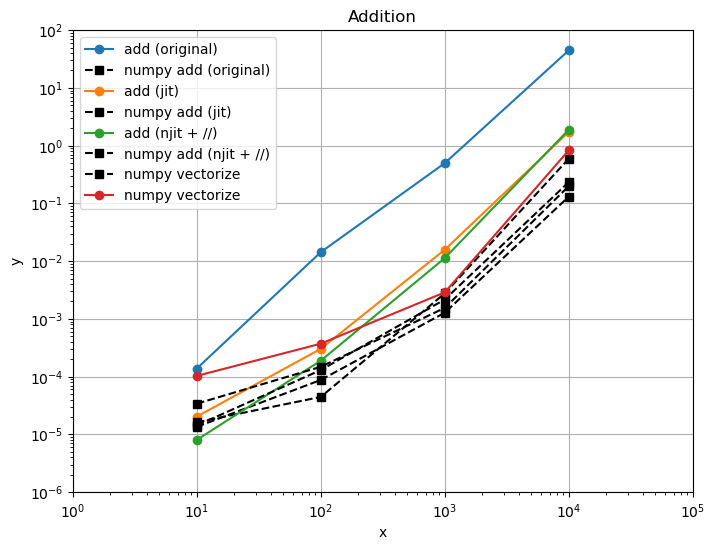

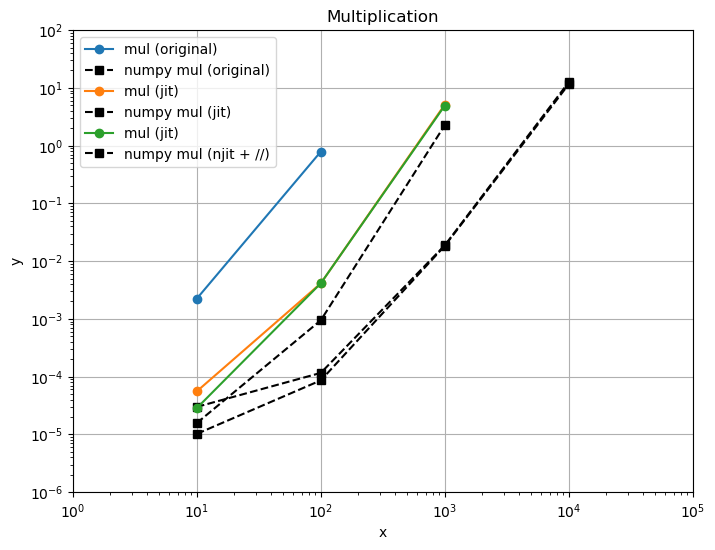

In [49]:
# General plots

plt.figure( figsize=(8,6) )
plt.title('Addition')
plt.plot([10,100,1000,10000], [0.000138, 0.0143, 0.498, 44.6],      '-o', label='add (original)')
plt.plot([10,100,1000,10000], [1.35e-05, 8.76e-05, 0.00128, 0.131], '--sk', label='numpy add (original)')
plt.plot([10,100,1000,10000], [2.03e-05, 0.000303, 0.0158, 1.73],  '-o', label='add (jit)')
plt.plot([10,100,1000,10000], [1.62e-05, 4.45e-05, 0.00277, 0.595], '--sk', label='numpy add (jit)')
plt.plot([10,100,1000,10000], [8.03e-06, 0.000189, 0.0113, 1.89],  '-o', label='add (njit + //)')
plt.plot([10,100,1000,10000], [3.4e-05, 0.000148, 0.00155, 0.199], '--sk', label='numpy add (njit + //)')
plt.plot([10,100,1000,10000], [1.43e-05, 0.00013, 0.00217, 0.234], '--sk', label='numpy vectorize')
plt.plot([10,100,1000,10000], [0.000103, 0.000372, 0.00288, 0.831], '-o', label='numpy vectorize')
plt.xlabel('x')
plt.ylabel('y')
plt.xscale('log')
plt.yscale('log')
plt.xlim([1, 100000])
plt.ylim([1e-6, 1e2])
plt.grid('on')
plt.legend()
plt.show()


plt.figure( figsize=(8,6) )
plt.title('Multiplication')
plt.plot([10,100], [0.00224, 0.787],                '-o', label='mul (original)')
plt.plot([10,100,1000], [1.57e-05, 0.000945, 2.26], '--sk', label='numpy mul (original)')
plt.plot([10,100,1000], [5.56e-05, 0.00412, 5.15],  '-o', label='mul (jit)')
plt.plot([10,100,1000, 10000], [2.99e-05, 0.000116, 0.0188, 12.6], '--sk', label='numpy mul (jit)')
plt.plot([10,100,1000], [2.85e-05, 0.00413, 4.94],  '-o', label='mul (jit)')
plt.plot([10,100,1000, 10000], [1.02e-05, 8.61e-05, 0.0184, 11.6], '--sk', label='numpy mul (njit + //)')
plt.xlabel('x')
plt.ylabel('y')
plt.xscale('log')
plt.yscale('log')
plt.xlim([1, 100000])
plt.ylim([1e-6, 1e2])
plt.grid('on')
plt.legend()
plt.show()

In [ ]:
# # -------------------------------
# # Python implementations
# # -------------------------------

# def add(mat1, mat2):
#     """ Element-wise addition of two matrices. """
#     if len(mat1) != len(mat2) or len(mat1[0]) != len(mat2[0]):
#         raise ValueError("Matrices must have the same dimensions")
#     m, n = len(mat1), len(mat1[0])
#     result = [[0] * n for _ in range(m)]
#     for i in range(m):
#         for j in range(n):
#             result[i][j] = mat1[i][j] + mat2[i][j]
#     return result

# def mul(mat1, mat2):
#     """ Multiply two matrices. """
#     m, n = len(mat1), len(mat1[0])
#     n2, p = len(mat2), len(mat2[0])
#     if n != n2:
#         raise ValueError("Incompatible dimensions for multiplication")
#     result = [[0] * p for _ in range(m)]
#     for i in range(m):
#         for j in range(p):
#             for k in range(n):
#                 result[i][j] += mat1[i][k] * mat2[k][j]
#     return result

# # -------------------------------
# # Numba compiled versions
# # -------------------------------

# # 1. Using @jit for addition
# @jit(nopython=True)
# def add_jit(mat1, mat2):
#     m, n = mat1.shape
#     result = np.empty((m, n), dtype=mat1.dtype)
#     for i in range(m):
#         for j in range(n):
#             result[i, j] = mat1[i, j] + mat2[i, j]
#     return result

# # 2. Using @njit with parallel=True for multiplication
# @njit(parallel=True)
# def mul_njit(mat1, mat2):
#     m, n = mat1.shape
#     n2, p = mat2.shape
#     result = np.zeros((m, p), dtype=mat1.dtype)
#     for i in prange(m):
#         for j in range(p):
#             for k in range(n):
#                 result[i, j] += mat1[i, k] * mat2[k, j]
#     return result

# # 3. Using @vectorize for element-wise addition
# # Note: vectorize creates a universal function (ufunc) for element-wise operations.
# @vectorize(['int32(int32, int32)', 'float64(float64, float64)'])
# def add_vectorized(a, b):
#     return a + b

# # 4. Using @cuda.jit for multiplication
# # GPU kernels require explicit thread indexing.
# @cuda.jit
# def mul_cuda(mat1, mat2, result):
#     # Define an (i, j) index for the result matrix
#     i, j = cuda.grid(2)
#     m, n = mat1.shape
#     n2, p = mat2.shape
#     if i < m and j < p:
#         tmp = 0
#         for k in range(n):
#             tmp += mat1[i, k] * mat2[k, j]
#         result[i, j] = tmp

# # -------------------------------
# # Example usage
# # -------------------------------
# if __name__ == "__main__":
#     # Create example matrices as NumPy arrays
#     A = np.array([[1, 2, 3],
#                   [4, 5, 6]], dtype=np.int32)
#     B = np.array([[7, 8],
#                   [9, 10],
#                   [11, 12]], dtype=np.int32)

#     # Using jit compiled addition (convert lists to arrays for Numba versions)
#     C = add_jit(A, A)
#     print("add_jit result:")
#     print(C)

#     # Using njit compiled multiplication with parallel=True
#     D = mul_njit(A, B)
#     print("mul_njit result:")
#     print(D)

#     # Using vectorized addition (element-wise)
#     E = add_vectorized(A, A)
#     print("add_vectorized result:")
#     print(E)

#     # Using cuda.jit for multiplication
#     # Define grid dimensions and allocate output array
#     m, n = A.shape
#     n2, p = B.shape
#     result_cuda = np.zeros((m, p), dtype=np.int32)
#     threads_per_block = (16, 16)
#     blocks_per_grid_x = (m + threads_per_block[0] - 1) // threads_per_block[0]
#     blocks_per_grid_y = (p + threads_per_block[1] - 1) // threads_per_block[1]
#     blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

#     # Launch the kernel
#     mul_cuda[blocks_per_grid, threads_per_block](A, B, result_cuda)
#     # Wait for GPU to complete computation
#     cuda.synchronize()
#     print("mul_cuda result:")
#     print(result_cuda)
